In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import arrow
from scipy.signal import savgol_filter 
import numpy as np
from lmfit.models import SkewedGaussianModel

In [2]:
# data from: http://ncov.mohw.go.kr/
df = pd.read_csv("all.csv").loc[1:].reset_index()
df["counts"] = [float(c.replace(",", "")) for c in df["계(명)"]]
df["savgol"] = savgol_filter([float(c.replace(",", "")) for c in df["계(명)"]], 7, 2)
df["ts"] = pd.to_datetime([str(arrow.get(t)) for t in df["일자"]])
df["rolling_avg"] = df["counts"].rolling(7).mean()
df.tail()

,index,일자,계(명),계(명).1,해외유입(명),사망(명),counts,savgol,ts,rolling_avg
807,808,2022.4.7,"224,820","224,780",40,348,224820.0,252155.380952,2022-04-07 00:00:00+00:00,240454.857143
808,809,2022.4.8,"205,333","205,325",8,373,205333.0,216087.904762,2022-04-08 00:00:00+00:00,229749.142857
809,810,2022.4.9,"185,566","185,526",40,338,185566.0,184032.214286,2022-04-09 00:00:00+00:00,218519.857143
810,811,2022.4.10,"164,481","164,454",27,329,164481.0,145615.214286,2022-04-10 00:00:00+00:00,208545.571429
811,812,2022.4.11,"90,928","90,907",21,258,90928.0,100836.904762,2022-04-11 00:00:00+00:00,203365.285714


In [3]:
df["weekday"] = [t.weekday() for t in df.ts]
df["counts_vs_rolling_avg"] = (df['counts'] - df['rolling_avg']) / df['rolling_avg']

df_for_weekdaytype = df[780:809].reset_index()
weekday_filter_weights = []
for weeknum in range(7):
    dat = df_for_weekdaytype.loc[df_for_weekdaytype.weekday == weeknum].counts_vs_rolling_avg.to_numpy()
    weekday_filter_weights.append(np.median(dat))
    
weekday_filter_weights

[-0.45984489044417665,
 -0.010375245588724536,
 0.19402192202001067,
 0.03203274687910064,
 -0.051317705233094146,
 -0.0510811275159606,
 -0.12838768882025478]

In [4]:
def skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=False, weighted=False, show_plots=True):
    """
    Parameters
    ----------
    target_y: univariate series to fit. 
    start_idx: start index
    df: whole dataframe
    show_stats: bool for plotting figs.
    weighted=False: bool for weighted fitting. If True, more recent data points get more weights on fitting. 
    
    """
    window_length = len(df) - start_idx
    april = pd.to_datetime([f"2022-04-{x}T00:00:00+00:00'" for x in range(1,31)]).to_list()
    may = pd.to_datetime([f"2022-05-{x}T00:00:00+00:00'" for x in range(1,32)]).to_list()
    whole_date = df["ts"].to_list() + april + may

    whole_date = sorted(list(set(whole_date)))
    xvals = np.arange(0, window_length)
    yvals = target_y[start_idx:]

    model = SkewedGaussianModel()

    # set initial parameter values
    params = model.make_params(amplitude=13639305., center=102.12, sigma=22.41, gamma=0)

    # adjust parameters  to best fit data.
    if weighted:
        result = model.fit(yvals, params, x=xvals, weights=xvals + 50)
    else:
        result = model.fit(yvals, params, x=xvals)
    
    if show_stats:
        print(result.fit_report())

    expected = result.eval(x=np.arange(-20, window_length+35))
    if show_plots:
        plt.figure(figsize=(6.5, 3))
        plt.title("fitting")
        plt.plot(xvals, yvals, 'd')
        ex = result.eval(x=xvals)
        plt.plot(xvals, ex)
        
        plt.figure(figsize=(8, 3))
        plt.plot(whole_date[start_idx-20:start_idx+window_length],  target_y[start_idx-20:], 'd', label="daily Covid cases")
        plt.plot(whole_date[start_idx-20:start_idx+window_length+35], expected, label="skewed gaussian fitting")
        plt.legend()
        plt.title("Forecasting Korean Covid cases")
        plt.xticks(whole_date[start_idx-20:start_idx+window_length+35][::15])
        
    return whole_date[start_idx-20:start_idx+window_length+35], target_y[start_idx-20:], expected


def weekday_filter(data, weeknum_series):
    filtered = []
    for data_single, weeknum in zip(data, weeknum_series):
        result = data_single * (weekday_filter_weights[weeknum]+1)
        filtered.append(result)
        
    return filtered
        
    

## 7-day rolling avg & original confirmed cases

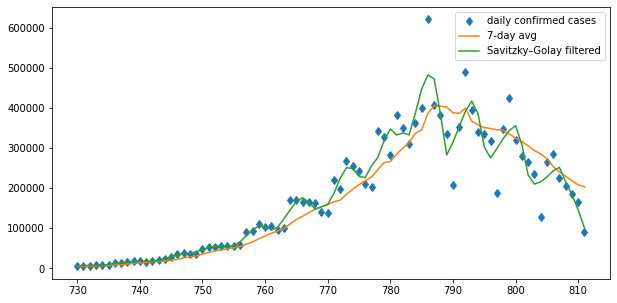

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df.counts[730:], 'd', label="daily confirmed cases")
df.rolling_avg[730:].plot(label="7-day avg")
df.savgol[730:].plot(label="Savitzky–Golay filtered")
plt.legend()

## skewed normal fifting using original data

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 191
    # data points      = 42
    # variables        = 4
    chi-square         = 1.9178e+11
    reduced chi-square = 5.0469e+09
    Akaike info crit   = 942.162227
    Bayesian info crit = 949.112906
[[Variables]]
    amplitude:  14962910.9 +/- 1005966.20 (6.72%) (init = 1.363930e+07)
    center:     5.98942723 +/- 3.77640774 (63.05%) (init = 102.12)
    sigma:      22.1440384 +/- 5.65562029 (25.54%) (init = 22.41)
    gamma:      1.79530308 +/- 1.40299773 (78.15%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.968
    C(sigma, gamma)      = 0.942
    C(center, gamma)     = -0.938
    C(amplitude, sigma)  = 0.528
    C(amplitude, center) = -0.462
    C(amplitude, gamma)  = 0.278
next day(2022-04-12 00:00:00+00:00) prediction: 141957


Text(0.5, 1.0, 'Predicting Covid cases in Korea')

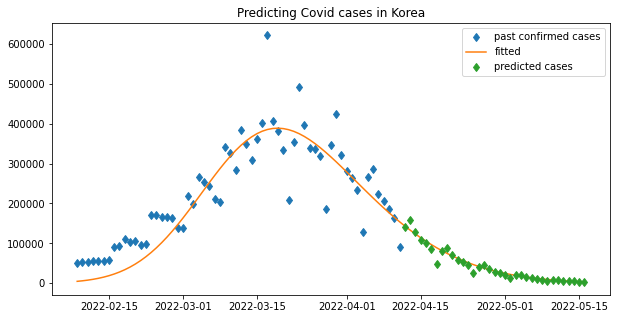

In [6]:
target_y = df.counts
start_idx = 770

x, y, y_expect = skewed_gaussian_fitting_n_plot(target_y, start_idx, df,
                                                show_stats=True,
                                                show_plots=False)

window_length = len(df) - start_idx
weekday_series = [t.weekday() for t in x]
filtered_data = weekday_filter(y_expect, weekday_series)

plt.figure(figsize=(10, 5))
plt.plot(x[:len(y)], y, 'd', label="past confirmed cases")
plt.plot(x, y_expect, label="fitted")
plt.plot(x[len(y):], filtered_data[len(y):], 'd', label='predicted cases')
plt.legend()
print(f"next day({x[len(y)]}) prediction:", int(filtered_data[len(y)]))
plt.title("Predicting Covid cases in Korea")

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 221
    # data points      = 42
    # variables        = 4
    chi-square         = 9.7703e+14
    reduced chi-square = 2.5711e+13
    Akaike info crit   = 1300.67038
    Bayesian info crit = 1307.62106
[[Variables]]
    amplitude:  14950100.2 +/- 1011646.98 (6.77%) (init = 1.363930e+07)
    center:     5.97619177 +/- 3.57008044 (59.74%) (init = 102.12)
    sigma:      22.1609270 +/- 5.18797225 (23.41%) (init = 22.41)
    gamma:      1.80964595 +/- 1.43656440 (79.38%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.963
    C(sigma, gamma)      = 0.926
    C(center, gamma)     = -0.895
    C(amplitude, center) = -0.356
    C(amplitude, sigma)  = 0.333
next day(2022-04-12 00:00:00+00:00) prediction: 141893


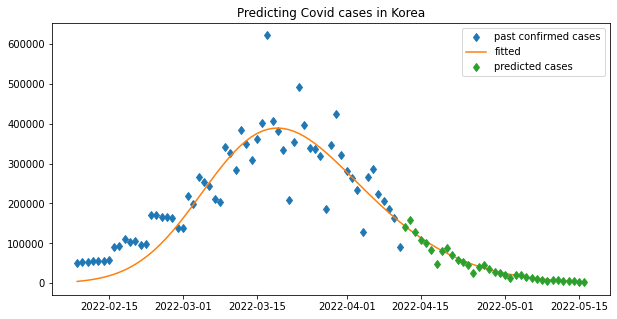

In [7]:
target_y = df.counts
start_idx = 770

x, y, y_expect = skewed_gaussian_fitting_n_plot(target_y, start_idx, df,
                                                show_stats=True,
                                                show_plots=False,
                                                weighted=True)

window_length = len(df) - start_idx
weekday_series = [t.weekday() for t in x]
filtered_data = weekday_filter(y_expect, weekday_series)

plt.figure(figsize=(10, 5))
plt.plot(x[:len(y)], y, 'd', label="past confirmed cases")
plt.plot(x, y_expect, label="fitted")
plt.plot(x[len(y):], filtered_data[len(y):], 'd', label='predicted cases')
plt.legend()
print(f"next day({x[len(y)]}) prediction:", int(filtered_data[len(y)]))
plt.title("Predicting Covid cases in Korea")
plt.savefig("figs/fitting_n_prediction.png", facecolor="w")

## skewed normal fifting using 7-day rolling avg

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 278
    # data points      = 42
    # variables        = 4
    chi-square         = 8.7065e+09
    reduced chi-square = 2.2912e+08
    Akaike info crit   = 812.286169
    Bayesian info crit = 819.236847
[[Variables]]
    amplitude:  15303792.2 +/- 290796.588 (1.90%) (init = 1.363930e+07)
    center:     9.41513551 +/- 1.54431599 (16.40%) (init = 102.12)
    sigma:      21.7591894 +/- 1.95442843 (8.98%) (init = 22.41)
    gamma:      1.46506240 +/- 0.37138572 (25.35%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.986
    C(center, gamma)     = -0.985
    C(sigma, gamma)      = 0.977
    C(amplitude, sigma)  = 0.765
    C(amplitude, center) = -0.700
    C(amplitude, gamma)  = 0.642


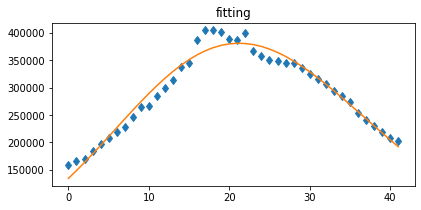

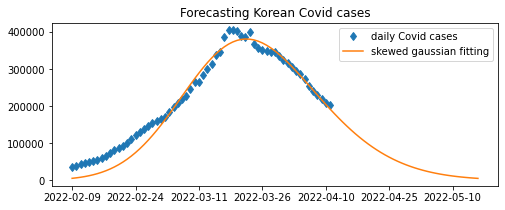

In [8]:
target_y = df.rolling_avg
start_idx = 770

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)
plt.show()

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 93
    # data points      = 42
    # variables        = 4
    chi-square         = 3.6970e+13
    reduced chi-square = 9.7289e+11
    Akaike info crit   = 1163.14500
    Bayesian info crit = 1170.09568
[[Variables]]
    amplitude:  15402260.9 +/- 244299.804 (1.59%) (init = 1.363930e+07)
    center:     8.41304148 +/- 0.92338886 (10.98%) (init = 102.12)
    sigma:      23.1359047 +/- 1.42378516 (6.15%) (init = 22.41)
    gamma:      1.77435722 +/- 0.31526017 (17.77%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.976
    C(sigma, gamma)      = 0.956
    C(center, gamma)     = -0.948
    C(amplitude, sigma)  = 0.695
    C(amplitude, center) = -0.668
    C(amplitude, gamma)  = 0.499


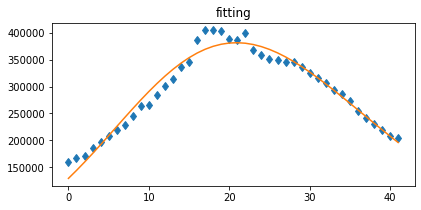

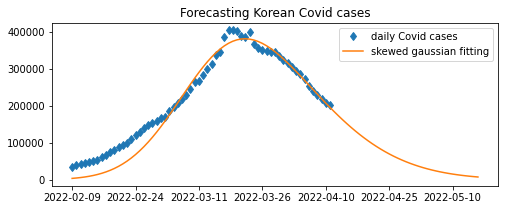

In [9]:
target_y = df.rolling_avg
start_idx = 770

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True, weighted=True)
plt.show()

## skewed normal fifting using Savitzky–Golay filtered signal

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 185
    # data points      = 42
    # variables        = 4
    chi-square         = 7.4288e+10
    reduced chi-square = 1.9549e+09
    Akaike info crit   = 902.328887
    Bayesian info crit = 909.279565
[[Variables]]
    amplitude:  14957262.8 +/- 625198.739 (4.18%) (init = 1.363930e+07)
    center:     6.05463401 +/- 2.42608900 (40.07%) (init = 102.12)
    sigma:      22.0428741 +/- 3.56688244 (16.18%) (init = 22.41)
    gamma:      1.76831906 +/- 0.87673515 (49.58%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.970
    C(sigma, gamma)      = 0.945
    C(center, gamma)     = -0.942
    C(amplitude, sigma)  = 0.521
    C(amplitude, center) = -0.455
    C(amplitude, gamma)  = 0.275


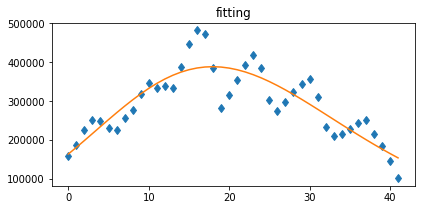

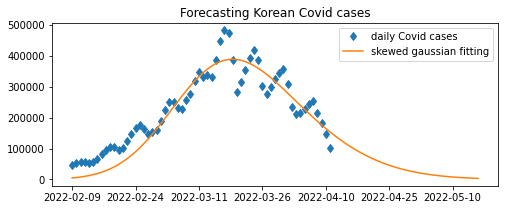

In [13]:
target_y = df.savgol
start_idx = 770

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)
plt.show()


[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 229
    # data points      = 42
    # variables        = 4
    chi-square         = 3.8418e+14
    reduced chi-square = 1.0110e+13
    Akaike info crit   = 1261.46700
    Bayesian info crit = 1268.41768
[[Variables]]
    amplitude:  14944526.1 +/- 634362.475 (4.24%) (init = 1.363930e+07)
    center:     6.03493847 +/- 2.30028917 (38.12%) (init = 102.12)
    sigma:      22.0684683 +/- 3.29281277 (14.92%) (init = 22.41)
    gamma:      1.78494637 +/- 0.90314932 (50.60%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.965
    C(sigma, gamma)      = 0.929
    C(center, gamma)     = -0.901
    C(amplitude, center) = -0.346
    C(amplitude, sigma)  = 0.326


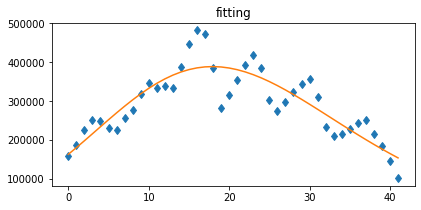

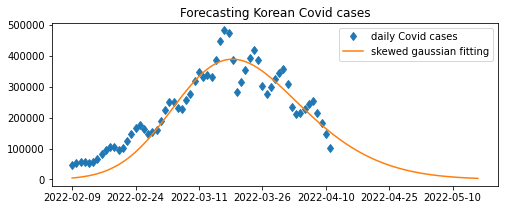

In [12]:
target_y = df.savgol
start_idx = 770

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True, weighted=True)
plt.show()